## Problem Statement: Predict the pay-range a given employee would belong to, based on the analysis of different attributes of other employees & their respective pay-range.

#### *The dataset is sourced from http://openbook.sfgov.org, which is part of the Government of San Francisco city's initiative in providing open & easily accessible data related to performance & spending across different departments of San Francisco City government. Salary range is the range of pay established by employers to pay to employees performing a particular job or function. Salary range generally has a minimum pay rate, a maximum pay rate, and a series of mid-range opportunities for pay increases.*

#### *The salary range is determined by market pay rates, organization, department, union, type and domain of jobs, established through market pay studies, for people doing similar work in similar industries in the same region of the country. Pay rates and salary ranges are also set up by individual employers and recognize the level of education, knowledge, skill, and experience needed to perform each job. Its a database of the salary and benefits paid to City employees since fiscal year 2013.*

#### *This data is summarized and presented on the Employee Compensation report hosted at http://openbook.sfgov.org*

#### *The target/label comprises of the 3 pay-range:* 
#### *1. Low range salary*
#### *2. Mid range salary*
#### *3. High range salary*

### *The objective of this notebook is to understand the impact of using Imblearn libraries on an imbalanced dataset*

In [2]:
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn import decomposition

#### *The dataset is given in 2 sets: train & test, wherein the test set doesn't have the labels marked. Thus the train set has to be split for actual training & validation*

In [4]:
train=pd.read_csv('/Users/debajyotidas/Documents/GitHub/Understanding the performance of LightGBM and XGBoost/data/train.csv')
test=pd.read_csv('/Users/debajyotidas/Documents/GitHub/Understanding the performance of LightGBM and XGBoost/data/test.csv')

In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149087 entries, 0 to 149086
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       149087 non-null  int64  
 1   Year Type                149087 non-null  object 
 2   Year                     149087 non-null  int64  
 3   Organization Group Code  149087 non-null  int64  
 4   Organization Group       149087 non-null  object 
 5   Department Code          149087 non-null  object 
 6   Department               149087 non-null  object 
 7   Union Code               149087 non-null  int64  
 8   Union                    149087 non-null  object 
 9   Job Family Code          149087 non-null  object 
 10  Job Family               149087 non-null  object 
 11  Job Code                 149087 non-null  object 
 12  Job                      149087 non-null  object 
 13  Employee Identifier      149087 non-null  int64  
 14  Over

In [92]:
train['Class'].value_counts()

3    50811
2    49604
1    48672
Name: Class, dtype: int64

#### *There are altogether 19 features & 1 label distributed across approx. 150 thousand datapoints. Of these 19 features, some are string/object type while the others are numerical (integer or floating point). Most ML algorithms work well with numerical data, and non-numerical categorical data usually needs to be ENCODED into some numerical form or the other.* 
#### *Some of these features may be redundant, while others may be not so important. We will inspect them individually*
#### *Lastly the target variable comprises of 3 classes and the classes seem to be slightly imbalanced. We can try introducing synthetic methods like SMOTE & RandomUnderSampler to handle this imbalance, so that the model is capable of classifying all the 3 classes equally well*

In [93]:
train.head()

,ID,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,...,Job Code,Job,Employee Identifier,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits,Class
0,9248,Fiscal,2017,3,Human Welfare & Neighborhood Development,DSS,HSA Human Services Agency,535,"SEIU - Human Services, Local 1021",2900,...,2905,Senior Eligibility Worker,41351,0.00,240.00,11896.36,13765.55,5248.43,30910.34,2
1,44541,Fiscal,2014,6,General Administration & Finance,ASR,ASR Assessor / Recorder,21,"Prof & Tech Engineers - Miscellaneous, Local 21",4200,...,4222,Sr Personal Property Auditor,41792,0.00,400.00,15429.94,9337.37,5599.01,30366.32,2
2,47031,Fiscal,2014,3,Human Welfare & Neighborhood Development,DSS,HSA Human Services Agency,535,"SEIU - Human Services, Local 1021",2900,...,2910,Social Worker,9357,0.00,1080.00,9682.00,8848.03,3463.92,21993.95,2
3,139416,Fiscal,2014,1,Public Protection,FIR,FIR Fire Department,798,"Firefighters - Miscellaneous, Local 798",H000,...,H002,Firefighter,28022,25730.46,18414.18,24222.26,13911.13,2416.58,40549.97,3
4,123780,Fiscal,2013,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,790,"SEIU - Miscellaneous, Local 1021",1600,...,1224,Pr Payroll & Personnel Clerk,51052,1138.28,2148.11,15437.62,12828.15,7246.54,35512.31,3


In [5]:
label_encoder = LabelEncoder()
lbl_binarizer1 = LabelBinarizer()
lbl_binarizer2 = LabelBinarizer()
lbl_binarizer3 = LabelBinarizer()
train['Year']= label_encoder.fit_transform(train['Year'])
train['Department Code']= lbl_binarizer1.fit_transform(train['Department Code'])
train['Job Family Code']= lbl_binarizer2.fit_transform(train['Job Family Code'])
train['Job Code']= lbl_binarizer3.fit_transform(train['Job Code'])

In [6]:
test['Year']= label_encoder.fit_transform(test['Year'])
test['Department Code']= lbl_binarizer1.transform(test['Department Code'])
test['Job Family Code']= lbl_binarizer2.transform(test['Job Family Code'])
test['Job Code']= lbl_binarizer3.transform(test['Job Code'])

#### *We first fit the encoder objects on the training data & then transform the same. The same object is then also used to transform the test data. As in this case we are using the train data for both training & validation, it would have been necessary to perform any transformative functions like scaling on the training data after splitting the same for training & testing. Fortunately such activity has not been needed due to our choice of ML algorithm, Tree based Classifiers - Random Forest & XGBClassifier, followed by stacking the 2*

#### *LabelBinarizer helps in generating one-hot encoded data from multi-class object/string data. LabelEncoder helps in generating ordered numeric feature by encoding ordinal numeric/object data*

<AxesSubplot:>

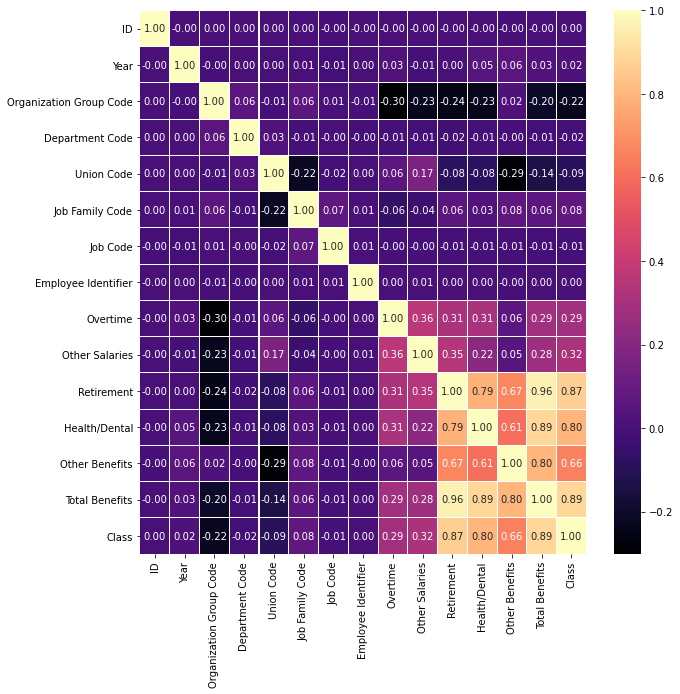

In [96]:
fig,ax = plt.subplots(figsize=(10, 10))   
sns.heatmap(train.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma") 

#### *From the above description we can see that the columns 'Organization Group','Department','Union','Job Family','Job','Employee Identifier','Year Type' are either redundant or are containing not important information. The same information as 'Organization Group','Department','Union','Job Family', and 'Job' is contained in 'Organization Group Code','Department Code','Union Code','Job Family Code',and 'Job Code' respectively. This data being available in numeric format is more suitable for analysis.*

#### *Additionally, information like 'Year Type','ID' and 'Employee Identifier' are either not unique for different employees or there is no visible strong correlation between the same & the target variable 'Class'. Thus we can drop them also.*

In [7]:
train.drop(columns=['ID','Organization Group','Department','Union',
                    'Job Family','Job','Employee Identifier','Year Type'],axis=1,inplace=True)

test.drop(columns=['ID','Organization Group','Department','Union',
                   'Job Family','Job','Employee Identifier', 'Year Type'],axis=1,inplace=True)

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149087 entries, 0 to 149086
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Year                     149087 non-null  int64  
 1   Organization Group Code  149087 non-null  int64  
 2   Department Code          149087 non-null  int64  
 3   Union Code               149087 non-null  int64  
 4   Job Family Code          149087 non-null  int64  
 5   Job Code                 149087 non-null  int64  
 6   Overtime                 149087 non-null  float64
 7   Other Salaries           149087 non-null  float64
 8   Retirement               149087 non-null  float64
 9   Health/Dental            149087 non-null  float64
 10  Other Benefits           149087 non-null  float64
 11  Total Benefits           149087 non-null  float64
 12  Class                    149087 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 14.8 MB


In [99]:
train.head()

,Year,Organization Group Code,Department Code,Union Code,Job Family Code,Job Code,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits,Class
0,4,3,0,535,0,0,0.00,240.00,11896.36,13765.55,5248.43,30910.34,2
1,1,6,0,21,0,0,0.00,400.00,15429.94,9337.37,5599.01,30366.32,2
2,1,3,0,535,0,0,0.00,1080.00,9682.00,8848.03,3463.92,21993.95,2
3,1,1,0,798,0,0,25730.46,18414.18,24222.26,13911.13,2416.58,40549.97,3
4,0,2,0,790,0,0,1138.28,2148.11,15437.62,12828.15,7246.54,35512.31,3


No handles with labels found to put in legend.


<AxesSubplot:xlabel='Overtime', ylabel='Density'>

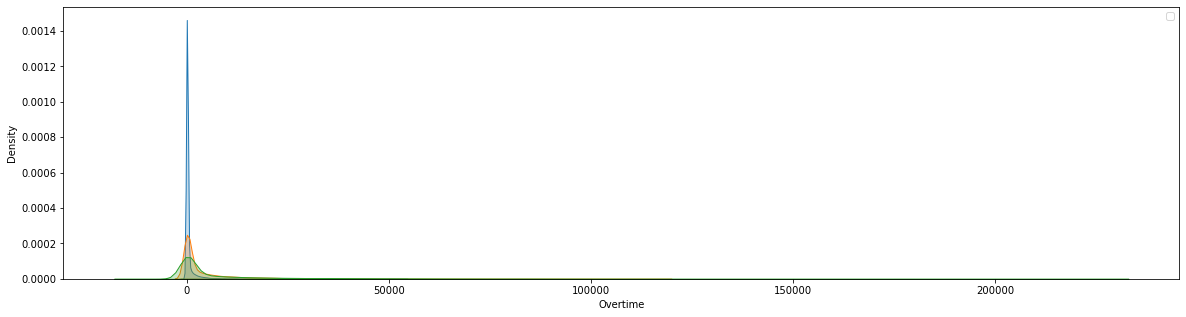

In [100]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Overtime')
sns.kdeplot(train[train['Class']==1]['Overtime'],label='Low Range',shade=True)
sns.kdeplot(train[train['Class']==2]['Overtime'],label='Mid Range',shade=True)
sns.kdeplot(train[train['Class']==3]['Overtime'],label='High Range',shade=True)

No handles with labels found to put in legend.


<AxesSubplot:xlabel='Other Salaries', ylabel='Density'>

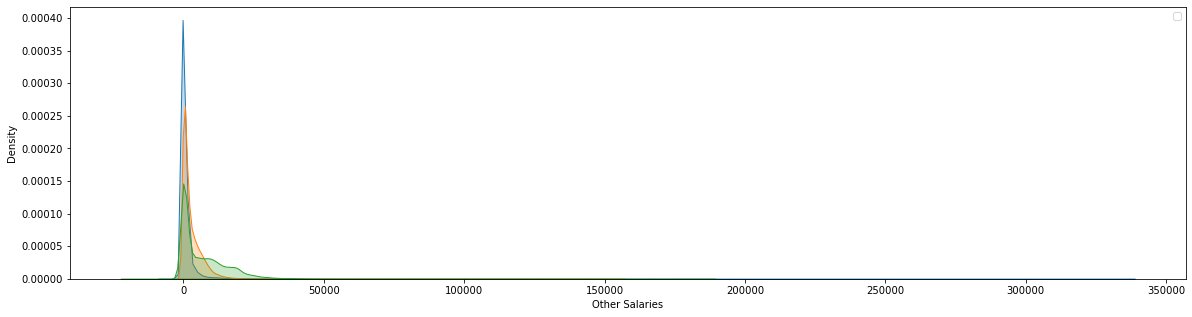

In [101]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Other Salaries')
sns.kdeplot(train[train['Class']==1]['Other Salaries'],label='Low Range', shade=True)
sns.kdeplot(train[train['Class']==2]['Other Salaries'],label='Mid Range', shade=True)
sns.kdeplot(train[train['Class']==3]['Other Salaries'],label='High Range', shade=True)

No handles with labels found to put in legend.


<AxesSubplot:xlabel='Retirement', ylabel='Density'>

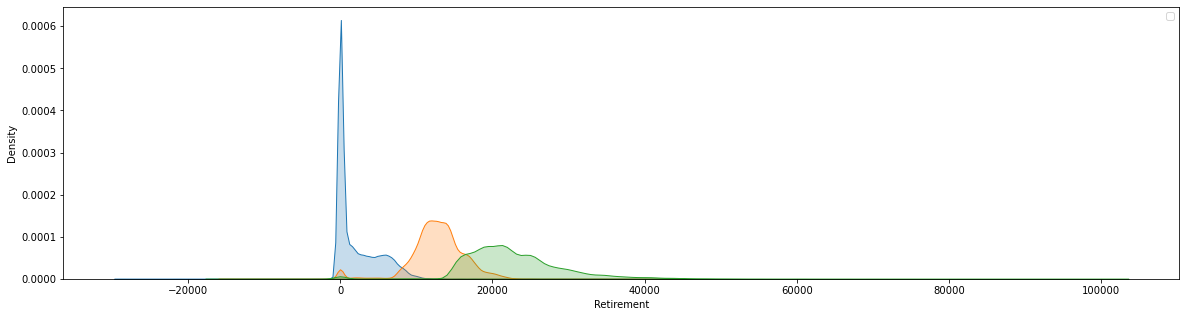

In [102]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Retirement')
sns.kdeplot(train[train['Class']==1]['Retirement'],label='Low Range', shade=True)
sns.kdeplot(train[train['Class']==2]['Retirement'],label='Mid Range', shade=True)
sns.kdeplot(train[train['Class']==3]['Retirement'],label='High Range', shade=True)

No handles with labels found to put in legend.


<AxesSubplot:xlabel='Health/Dental', ylabel='Density'>

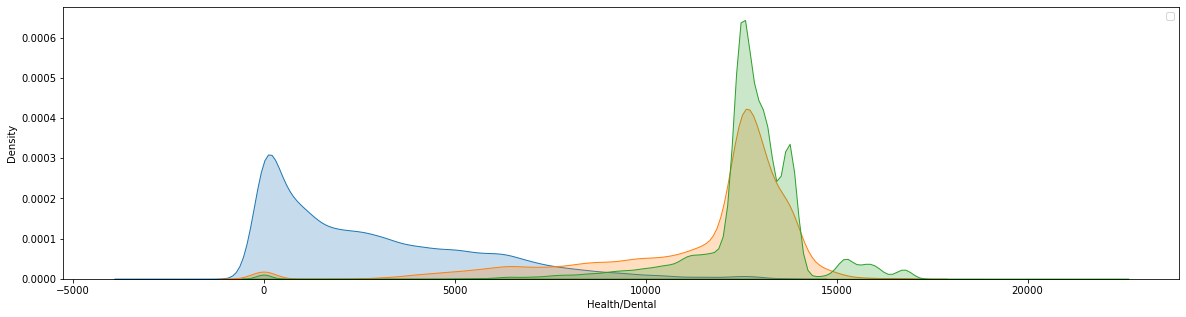

In [103]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Health/Dental')
sns.kdeplot(train[train['Class']==1]['Health/Dental'],label='Low Range', shade=True)
sns.kdeplot(train[train['Class']==2]['Health/Dental'],label='Mid Range', shade=True)
sns.kdeplot(train[train['Class']==3]['Health/Dental'],label='High Range', shade=True)

No handles with labels found to put in legend.


<AxesSubplot:xlabel='Other Benefits', ylabel='Density'>

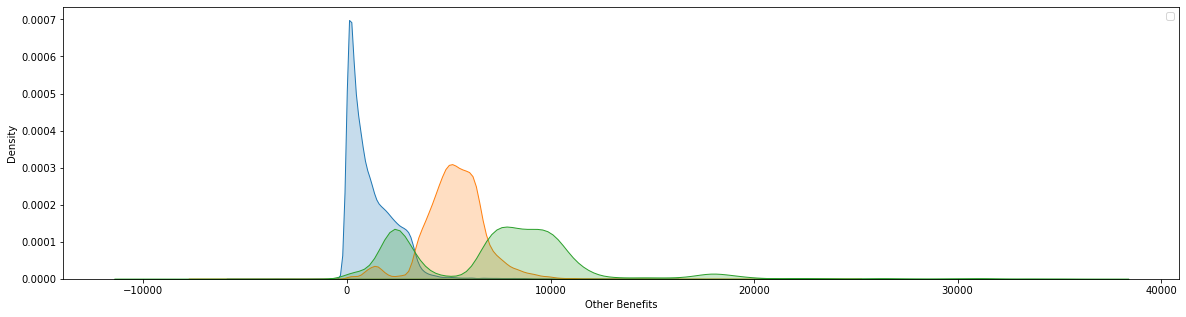

In [104]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Other Benefits')
sns.kdeplot(train[train['Class']==1]['Other Benefits'],label='Low Range', shade=True)
sns.kdeplot(train[train['Class']==2]['Other Benefits'],label='Mid Range', shade=True)
sns.kdeplot(train[train['Class']==3]['Other Benefits'],label='High Range', shade=True)

No handles with labels found to put in legend.


<AxesSubplot:xlabel='Total Benefits', ylabel='Density'>

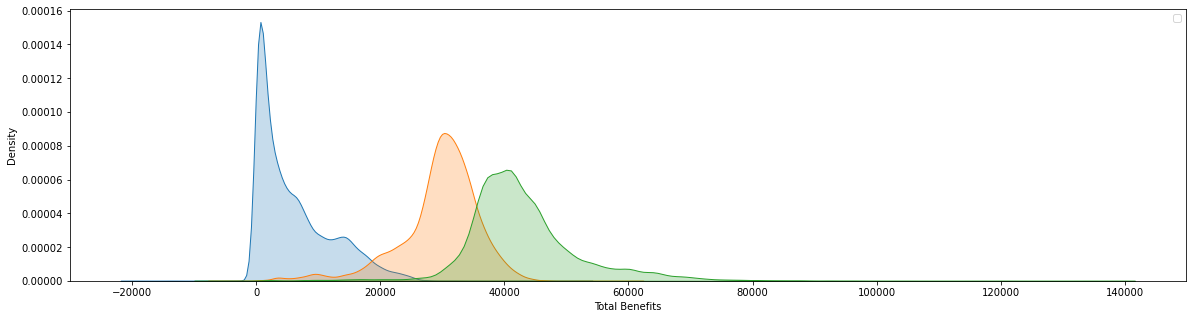

In [105]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Total Benefits')
sns.kdeplot(train[train['Class']==1]['Total Benefits'],label='Low Range', shade=True)
sns.kdeplot(train[train['Class']==2]['Total Benefits'],label='Mid Range', shade=True)
sns.kdeplot(train[train['Class']==3]['Total Benefits'],label='High Range', shade=True)

#### *It seems from the above EDA that Low Range employees receive mostly no Retirement, Other Salaries and Other Benefits. Thus oevrall amount of benefits received by Low Range earners is very less*

#### *In case of Mid Range earners, they seem to be the largest earners of Overtime. Their Other Salaries mostly seem to be zero, same as Low Range & High Range earners. Retirement benefits is less than High Range earners, but there is significant over-lap between the higher range of Retirement benefits of Mid Range earners & lower-range of Retirement benefits of High Range earners. Health/Dental benefits are identical with that of High Range earners while Other Benefits component is significantly higher for Mid Range earners, as compared to the other 2 class*

#### *High-Range earners mostly don't earn any Overtime or Other Salaries. As already seen, they earn slightly better Other Benefits & Retirals than Mid-Range earners, with whom they share similar Health/Dental benefits*

In [8]:
#Dropping the target column 'Class' from the train data & storing it into a new variable
y = train['Class']
train.drop('Class',axis=1,inplace=True)

#### *Splitting the train data into 2 sets for training & validation by a 70:30 split (test_size=0.3). Further this split will be done after ensuring that the features are distributed in the same proportions in the 2 datasets, i.e. if if the 3 classes were initially distributed in the main dataset in a 30:40:30 ratio, the same will be maintained in the x_train & x_val also. This is achieved by the 'stratify' command, although it may not provide useful in the current context as we will be employing Up-sampling & Down-sampling techniques.*
#### *The random_state ensures reproducability over multiple execution cycles*

In [9]:
x_train,x_val,y_train,y_val = train_test_split(train,y,test_size=0.3,random_state=42,stratify=y)

In [10]:
y_train.value_counts()

3    35567
2    34723
1    34070
Name: Class, dtype: int64

In [11]:
model = XGBClassifier(random_state=42, 
                      booster='gbtree', 
                      objective='multi:softmax', 
                      num_class=3, 
                      n_jobs=-1, 
                      learning_rate=0.3,            #default 
                      n_estimators=200, 
                      max_depth=6,                  #default
                      subsample=0.8,
                      tree_method='hist',
                      grow_policy='lossguide',
                      max_leaves=10,
                      max_bin=256,                  #default
                      eval_metric='mlogloss')

In [15]:
start_time = timeit.default_timer()
model.fit(x_train,y_train)
print ('\n','Training Accuracy is: ',model.score(x_train,y_train))
stop_time = timeit.default_timer()
print('\n','Total Training Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))

start_time = timeit.default_timer()
y_pred_test = model.predict(x_val)
stop_time = timeit.default_timer()
print ('\n','Testing Accuracy is: ',metrics.accuracy_score(y_val,y_pred_test))
print('\n','Total Testing Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))


 Training Accuracy is:  0.9932157914909927

 Total Training Time: 48.82 seconds.

 Testing Accuracy is:  0.9869877255349118

 Total Testing Time: 1.39 seconds.


In [16]:
#Viewing the classification report
print (metrics.classification_report(y_val,y_pred_test))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99     14602
           2       0.98      0.98      0.98     14881
           3       0.99      0.99      0.99     15244

    accuracy                           0.99     44727
   macro avg       0.99      0.99      0.99     44727
weighted avg       0.99      0.99      0.99     44727



In [27]:
model = LGBMClassifier(random_state=42, 
                      boosting_type='rf',
                      num_leaves=31,                #default
                      max_depth=-1,                 #default
                      learning_rate=0.3,
                      n_estimators=200,             
                      objective='multiclass', 
                      class_weight='balanced',      #to handle class imbalance
                      subsample=0.8,                #bagging ratio
                      subsample_freq=5,             #perform bagging at every 5th iteration
                      max_bin=255,                  #default
                      metric='multi_logloss'
                      )

In [28]:
start_time = timeit.default_timer()
model.fit(x_train,y_train)
print ('\n','Training Accuracy is: ',model.score(x_train,y_train))
stop_time = timeit.default_timer()
print('\n','Total Training Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))

start_time = timeit.default_timer()
y_pred_test = model.predict(x_val)
stop_time = timeit.default_timer()
print ('\n','Testing Accuracy is: ',metrics.accuracy_score(y_val,y_pred_test))
print('\n','Total Testing Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))


 Training Accuracy is:  0.9649961671138367

 Total Training Time: 41.4 seconds.

 Testing Accuracy is:  0.9632436783151117

 Total Testing Time: 2.81 seconds.


In [29]:
#Viewing the classification report
print (metrics.classification_report(y_val,y_pred_test))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98     14602
           2       0.95      0.95      0.95     14881
           3       0.97      0.96      0.97     15244

    accuracy                           0.96     44727
   macro avg       0.96      0.96      0.96     44727
weighted avg       0.96      0.96      0.96     44727



### Using PCA to verify if model accuracy can be increased. Later, we will try imbalanced learning on PCA data also

In [30]:
train=pd.read_csv('/Users/debajyotidas/Documents/GitHub/Understanding the performance of LightGBM and XGBoost/data/train.csv')
test=pd.read_csv('/Users/debajyotidas/Documents/GitHub/Understanding the performance of LightGBM and XGBoost/data/test.csv')

In [31]:
label_encoder = LabelEncoder()
lbl_binarizer1 = LabelBinarizer()
lbl_binarizer2 = LabelBinarizer()
lbl_binarizer3 = LabelBinarizer()
train['Year']= label_encoder.fit_transform(train['Year'])
train['Department Code']= lbl_binarizer1.fit_transform(train['Department Code'])
train['Job Family Code']= lbl_binarizer2.fit_transform(train['Job Family Code'])
train['Job Code']= lbl_binarizer3.fit_transform(train['Job Code'])

In [32]:
test['Year']= label_encoder.fit_transform(test['Year'])
test['Department Code']= lbl_binarizer1.transform(test['Department Code'])
test['Job Family Code']= lbl_binarizer2.transform(test['Job Family Code'])
test['Job Code']= lbl_binarizer3.transform(test['Job Code'])

<AxesSubplot:>

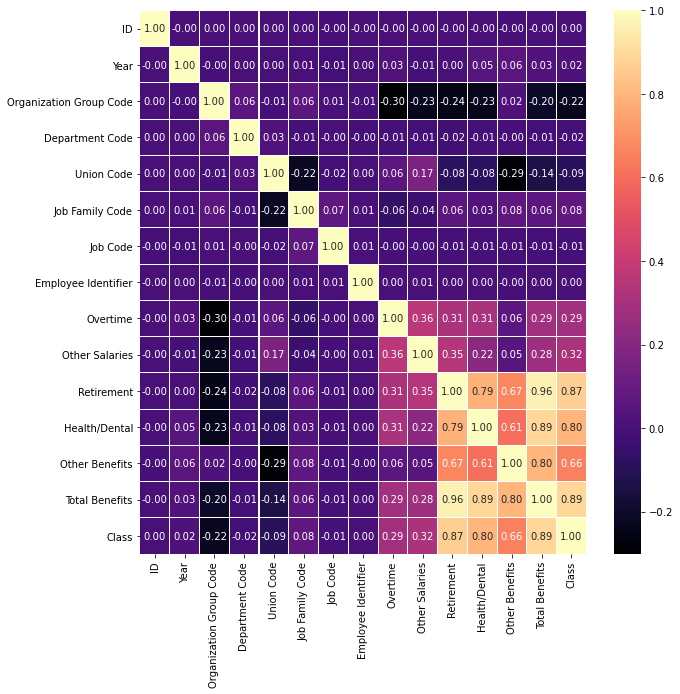

In [33]:
fig,ax = plt.subplots(figsize=(10, 10))   
sns.heatmap(train.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma") 

In [34]:
train[['Retirement','Health/Dental','Other Benefits','Total Benefits']].corr()

,Retirement,Health/Dental,Other Benefits,Total Benefits
Retirement,1.000000,0.787526,0.671137,0.962205
Health/Dental,0.787526,1.000000,0.606259,0.888821
Other Benefits,0.671137,0.606259,1.000000,0.796860
Total Benefits,0.962205,0.888821,0.796860,1.000000


#### *Looking to run PCA on the above columns which have high collinearity*

<AxesSubplot:>

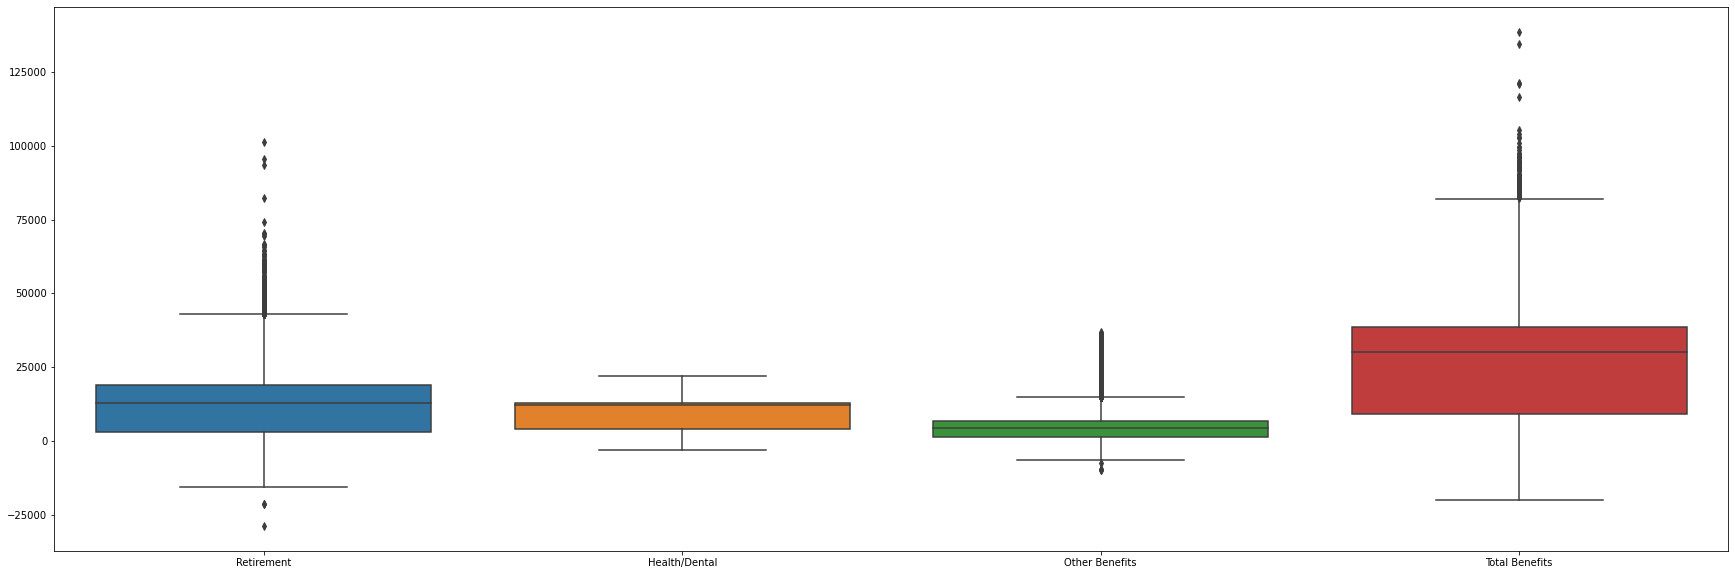

In [35]:
plt.figure(figsize=(30,10))
sns.boxplot(data=train[['Retirement','Health/Dental','Other Benefits','Total Benefits']])

In [36]:
scaler=StandardScaler()
pca=decomposition.PCA(n_components=3)

NameError: name 'decomposition' is not defined

In [129]:
columns=['Retirement','Health/Dental','Other Benefits','Total Benefits']
data_scaled = pd.DataFrame(scaler.fit_transform(train[['Retirement','Health/Dental','Other Benefits','Total Benefits']]),columns=columns)

<AxesSubplot:>

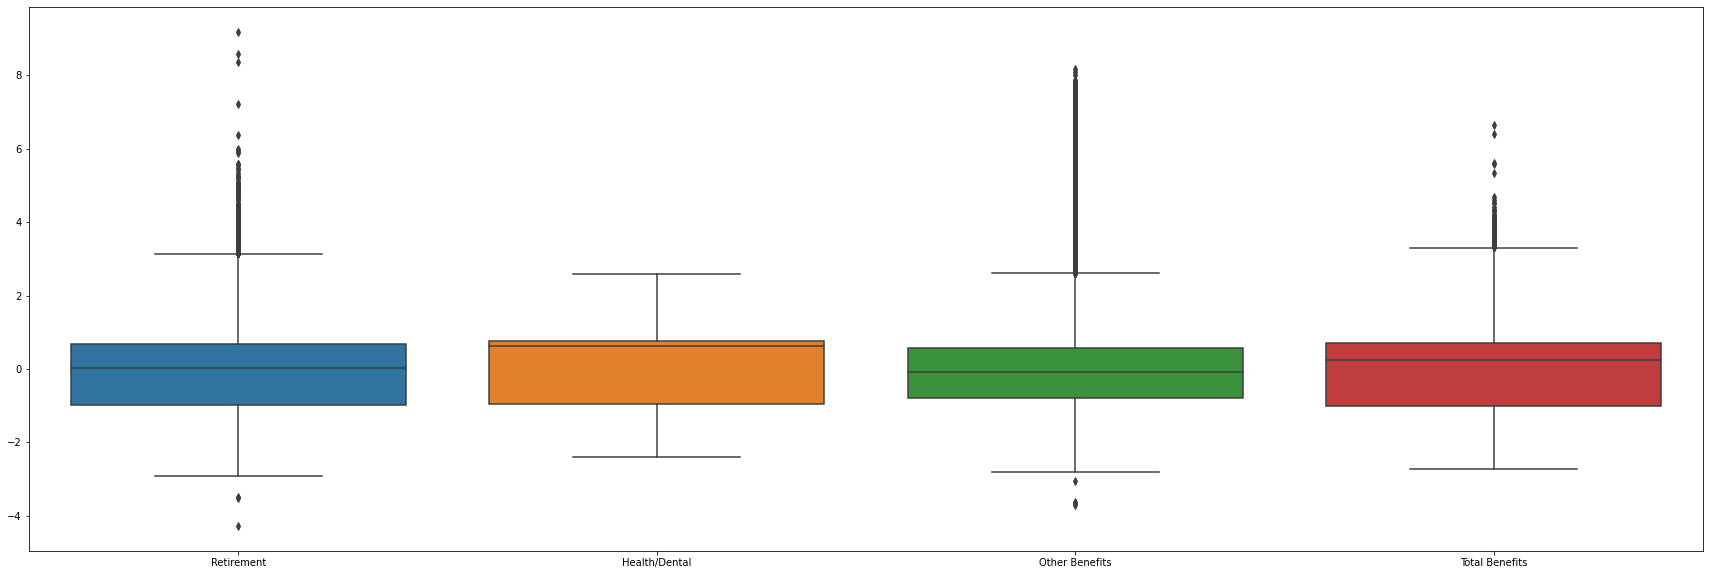

In [130]:
plt.figure(figsize=(30,10))
sns.boxplot(data=data_scaled)

In [131]:
# PCA
# Step 1 - Create covariance matrix
cov_matrix = np.cov(data_scaled.T)
# Step 2- Get eigen values and eigen vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
#Step 3- Understanding cumulative variance
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [ 84.25437992  94.72404974 100.         100.        ]


In [132]:
pcadata_reduced = pca.fit_transform(data_scaled)

In [133]:
proj_data_df = pd.DataFrame(pcadata_reduced)  # converting array to dataframe for pairplot
pca_df = proj_data_df.join(train)             # adding back the PCA to the main dataset

In [134]:
pca_df.head()

,0,1,ID,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,...,Job Code,Job,Employee Identifier,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits,Class
0,0.624622,-0.327289,9248,Fiscal,4,3,Human Welfare & Neighborhood Development,0,HSA Human Services Agency,535,...,0,Senior Eligibility Worker,41351,0.00,240.00,11896.36,13765.55,5248.43,30910.34,2
1,0.403335,0.081200,44541,Fiscal,1,6,General Administration & Finance,0,ASR Assessor / Recorder,21,...,0,Sr Personal Property Auditor,41792,0.00,400.00,15429.94,9337.37,5599.01,30366.32,2
2,-0.463135,-0.163763,47031,Fiscal,1,3,Human Welfare & Neighborhood Development,0,HSA Human Services Agency,535,...,0,Social Worker,9357,0.00,1080.00,9682.00,8848.03,3463.92,21993.95,2
3,1.275232,-1.284027,139416,Fiscal,1,1,Public Protection,0,FIR Fire Department,798,...,0,Firefighter,28022,25730.46,18414.18,24222.26,13911.13,2416.58,40549.97,3
4,1.098471,0.089262,123780,Fiscal,0,2,"Public Works, Transportation & Commerce",0,MTA Municipal Transprtn Agncy,790,...,0,Pr Payroll & Personnel Clerk,51052,1138.28,2148.11,15437.62,12828.15,7246.54,35512.31,3


In [135]:
data_scaled_test = pd.DataFrame(scaler.transform(test[['Retirement','Health/Dental','Other Benefits','Total Benefits']]),columns=columns)
pcadata_reduced_test = pca.transform(data_scaled_test)

In [136]:
proj_data_df_test = pd.DataFrame(pcadata_reduced_test)  # converting array to dataframe for pairplot
pca_df_test = proj_data_df_test.join(test) 

In [137]:
pca_df.drop(columns=['ID','Organization Group','Department','Union',
                    'Job Family','Job','Employee Identifier','Year Type',
                     'Retirement','Health/Dental','Other Benefits','Total Benefits'],axis=1,inplace=True)
pca_df_test.drop(columns=['ID','Organization Group','Department','Union',
                    'Job Family','Job','Employee Identifier','Year Type',
                     'Retirement','Health/Dental','Other Benefits','Total Benefits'],axis=1,inplace=True)

In [138]:
pca_df.head()

,0,1,Year,Organization Group Code,Department Code,Union Code,Job Family Code,Job Code,Overtime,Other Salaries,Class
0,0.624622,-0.327289,4,3,0,535,0,0,0.00,240.00,2
1,0.403335,0.081200,1,6,0,21,0,0,0.00,400.00,2
2,-0.463135,-0.163763,1,3,0,535,0,0,0.00,1080.00,2
3,1.275232,-1.284027,1,1,0,798,0,0,25730.46,18414.18,3
4,1.098471,0.089262,0,2,0,790,0,0,1138.28,2148.11,3


In [139]:
y = pca_df['Class']
pca_df.drop('Class',axis=1,inplace=True)

In [140]:
x_train,x_val,y_train,y_val = train_test_split(pca_df,y,test_size=0.3,random_state=42,stratify=y)

In [141]:
model2 = LGBMClassifier(random_state=42, 
                      boosting_type='rf',
                      num_leaves=31,                #default
                      max_depth=-1,                 #default
                      learning_rate=0.3,
                      n_estimators=200,             
                      objective='multiclass', 
                      class_weight='balanced',      #to handle class imbalance
                      subsample=0.8,                #bagging ratio
                      subsample_freq=5,             #perform bagging at every 5th iteration
                      max_bin=255,                  #default
                      metric='multi_logloss')

In [142]:
start_time = timeit.default_timer()
model2.fit(x_train,y_train)
print ('\n','Training Accuracy is: ',model2.score(x_train,y_train))
stop_time = timeit.default_timer()
print('\n','Total Training Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))

start_time = timeit.default_timer()
y_pred_test = model2.predict(x_val)
stop_time = timeit.default_timer()
print ('\n','Testing Accuracy is: ',metrics.accuracy_score(y_val,y_pred_test))
print('\n','Total Testing Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))


 Training Accuracy is:  1.0

 Total Training Time: 10.18 seconds.

 Testing Accuracy is:  0.9743108189684083

 Total Testing Time: 0.33 seconds.


In [143]:
#Viewing the classification report
print (metrics.classification_report(y_val,y_pred_test))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98     14602
           2       0.97      0.96      0.96     14881
           3       0.98      0.98      0.98     15244

    accuracy                           0.97     44727
   macro avg       0.97      0.97      0.97     44727
weighted avg       0.97      0.97      0.97     44727



### *LightGBM provides a much faster throughput than XGBoost. This is even more accentuated when some of the collinear features are replaced with equivalent Principal Components, with both training time & model accuracy improving considerably*